In [58]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string

from sklearn import model_selection
from sklearn import set_config
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import spacy
import nltk
from sklearn.svm import SVC

import seaborn as sns

# Pour éviter l'affichage tronqué des descriptions
pd.set_option('display.max_colwidth', None)
# Pour la visualisation des pipelines sklearn
set_config(display='diagram')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# First experimentations with english dataset and simple models

## 1. Importation des données

In [59]:
# Recuperation des données
tweet_df = pd.read_csv('data/tweets_eng.csv', index_col=0)

# Suppression des lignes avec des valeurs manquantes
tweet_df = tweet_df.dropna()

# Suppression des colonnes inutiles
tweet_df = tweet_df.drop(columns=['selected_text'])

In [60]:
tweet_df.head()

,text,sentiment
textID,,
cb774db0d1,"I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
088c60f138,my boss is bullying me...,negative
9642c003ef,what interview! leave me alone,negative
358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought",negative


In [61]:
tweet_df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [62]:
#drop the neutral tweets
tweet_df = tweet_df[tweet_df['sentiment'] != 'neutral']

In [63]:
# Convertit les genres en labels numériques (-1 et 1)
tweet_df['sentiment'] = tweet_df['sentiment'].map({'negative': -1, 'positive': 1})
# rename the column sentiment to label
tweet_df.rename(columns={'sentiment': 'label'}, inplace=True)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], tweet_df['label'], test_size=0.2, random_state=42, shuffle=True)

## 2. Preprocessing

In [65]:
# download spacy model
#!python3 -m spacy download en_core_web_sm

In [66]:
from preprocessing import preprocess_texts, preprocess_text

In [67]:
# preprocess X_train and X_test
X_train_pre = preprocess_texts(X_train,'stem',True)
X_test_pre = preprocess_texts(X_test, 'stem',True)

In [68]:
# convert X_train_pre, X_test_pre, y_train, y_test to numpy array
X_train_pre = np.array(X_train_pre)
X_test_pre = np.array(X_test_pre)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [69]:
# print the 10 first preprocessed texts
for i in range(10):
    print(X_train_pre[i])

total bereft fault everi way
kate know heap awesom not work weekend
wish go internet week
stayin dustin tonight car hate
not sound preacheri anyth iphon amaz havent issu sinc 20 firmwar wink wink
love hat cool look like fun day love use word crikey
im sad sad sad thought aunti stina come no look forward familyi miss dat im alon maui
walah 2 still not get full idea
thank agre httpbitly7vikc
cant believ wasnt follow anatomi prac tmw tonight im structr lwr limb


## X. Detection de sujet

In [71]:
#topic modeling on the preprocessed tweets

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer object
count_vectorizer = CountVectorizer(stop_words='english')

# fit and transform X_train_pre
count_train = count_vectorizer.fit_transform(X_train_pre)

# transform X_test_pre
count_test = count_vectorizer.transform(X_test_pre)

# create a LDA object
lda = LatentDirichletAllocation(n_components=10, random_state=42)

# fit the LDA model on the training data
lda.fit(count_train)

# transform the training and test data
lda_train = lda.transform(count_train)
lda_test = lda.transform(count_test)

# print the lda components
print(lda.components_)
print(lda.components_.shape)

# print the top 5 words for each topic
n_top_words = 5
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# print the first 5 rows of the lda_train
print(lda_train[:5])

[[0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.1        0.1        0.1        ... 1.09995901 0.1        1.09997731]
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 ...
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.1        0.1        1.0999879  ... 1.09999058 0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.10000846 0.1        0.1       ]]
(10, 14069)
Topic 1:
thank love follow im pleas
Topic 2:
sorri star im hear war
Topic 3:
sad im like look know
Topic 4:
na im want gon feel
Topic 5:
miss love think dont im
Topic 6:
day happi mother got mom
Topic 7:
im suck bore like night
Topic 8:
good morn love realli hope
Topic 9:
like dont im miss feel
Topic 10:
good think day great like
[[0.01666706 0.01666706 0.016668   0.01666813 0.01666838 0.01666958
  0.84998859 0.01666834 0.01666763 0.01666723]
 [0.01428802 0.01428707 0.01429264 0.0142877  0.01428814 0.01428738
  0.87140571 0.01428753 0.014

## 3. Pipeline TF-IDF

In [39]:
vectorizer = TfidfVectorizer(tokenizer = lambda x : str.split(x, ' '), min_df=0.0005)

In [28]:
""" prepro_stemming = FunctionTransformer(func=preprocess_texts,kw_args={'stem_lemm':'stem'})
prepro_lemmatize = FunctionTransformer(func=preprocess_texts, kw_args={'stem_lemm':'lemm'})

pipeline_stem = Pipeline([('preprocess_pipeline', prepro_stemming), ('vectorizer_pipeline', vectorizer)])
pipeline_lemm = Pipeline([('preprocess_pipeline', prepro_lemmatize), ('vectorizer_pipeline', vectorizer)]) """

" prepro_stemming = FunctionTransformer(func=preprocess_texts,kw_args={'stem_lemm':'stem'})\nprepro_lemmatize = FunctionTransformer(func=preprocess_texts, kw_args={'stem_lemm':'lemm'})\n\npipeline_stem = Pipeline([('preprocess_pipeline', prepro_stemming), ('vectorizer_pipeline', vectorizer)])\npipeline_lemm = Pipeline([('preprocess_pipeline', prepro_lemmatize), ('vectorizer_pipeline', vectorizer)]) "

## 4. Comparaison des modèles et des prétraitements

In [14]:
# testing different min_df values for tfidf vectorizer
""" min_df_values = [0, 0.0001, 0.0002, 0.0003 ,0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.001]
scoring = 'f1_macro'
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
for min_df in min_df_values:
    vectorizer = TfidfVectorizer(tokenizer = lambda x : str.split(x, ' '), min_df=min_df)
    model_pipeline = make_pipeline(vectorizer, SVC())
    # Entrainement du modèle
    model_pipeline.fit(X_train_pre, y_train)
    # Evaluation du modèle
    cv_results = model_selection.cross_val_score(model_pipeline, X_test_pre, y_test, cv=kfold, scoring=scoring)
    print("min_df = ", min_df, " : ", cv_results.mean()) """

min_df =  0  :  0.6229086601553337
min_df =  0.0001  :  0.6229086601553337
min_df =  0.0002  :  0.6229086601553337
min_df =  0.0003  :  0.6258285245167696
min_df =  0.0004  :  0.6258285245167696
min_df =  0.0005  :  0.6281340457638562
min_df =  0.0006  :  0.6281340457638562
min_df =  0.0007  :  0.6277118985314949
min_df =  0.0008  :  0.6277118985314949
min_df =  0.001  :  0.6271520343087422


In [52]:
# Modèles à tester
models = [
    ('Dummy', DummyClassifier(strategy='most_frequent')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('KNN', KNeighborsClassifier()),
]


# Evaluation des modèles et des pipelines
scores = []
names = []
scoring = 'f1_macro'
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
# Itération sur les modèles et les pipelines
for name, model in models:
    print(name)
    names.append(name)
    # Création de la pipeline pour le modèle
    model_pipeline = make_pipeline(vectorizer, model)
    # Entrainement du modèle
    model_pipeline.fit(X_train_pre, y_train)
    # Evaluation du modèle
    cv_results = model_selection.cross_val_score(model_pipeline, X_test_pre, y_test, cv=kfold, scoring=scoring)
    # Ajout du score moyen à la liste scores
    scores.append(cv_results.mean())

Dummy
Decision Tree
Random Forest
Logistic Regression
SVM
Multinomial Naive Bayes
KNN


In [53]:
# Print models name and accuracy
for i in range(len(names)):
    print(names[i], scores[i])

Dummy 0.33785159016386734
Decision Tree 0.7801800146035991
Random Forest 0.8281076765083017
Logistic Regression 0.8429185151273565
SVM 0.8499449183294978
Multinomial Naive Bayes 0.8287477376151363
KNN 0.4911522777710096


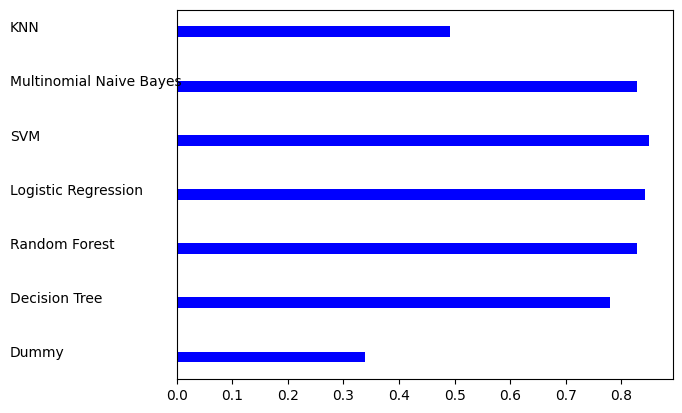

In [54]:
# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

## 5. Evaluation meilleur modèle

In [55]:
model_pipeline = make_pipeline(vectorizer, SVC())
model_pipeline.fit(X_train_pre, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=0.0005,
                                 tokenizer=<function <lambda> at 0x7fdfc1e11fc0>)),
                ('svc', SVC())])

              precision    recall  f1-score   support

          -1       0.87      0.88      0.88      1603
           1       0.89      0.87      0.88      1670

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



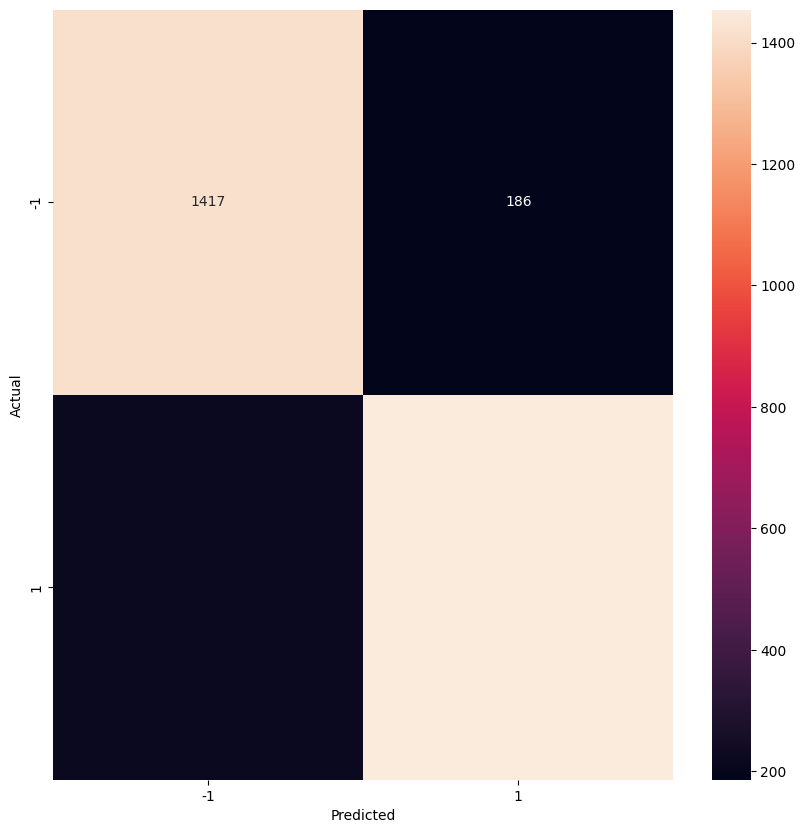

In [57]:
# Evaluation du modèle
y_pred = model_pipeline.predict(X_test_pre)
print(classification_report(y_test, y_pred))

# Matrice de confusion

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=tweet_df['label'].unique(), yticklabels=tweet_df['label'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()